# Instacart Market Basket Analysis

The Instacart dataset for prior orders, is quite large.  However, it could provide quite a bit of insight in our customer behavior, without touching our specified training and test sets.  The dataset provided by Instacart, has already been split between prior, train and test.  In order to avoid overfitting my training models, I will first leverage the prior dataset as a pre-training data set.

Also market basket analysis can be quite memory intensive.  As such, I would like to first attempt to segment my customers using RFM (Recency Frequency Monetary Value) in order to further reduce my dataset before running any models.  The instacart dataset doesn't provide the revenue figures or the sales prices for any of the products in the dataset.  Therefore, for this exercise, we will make the assumption that the number of products each customer ordered, could be an indicator of the Monetary value.

The recency of purchases has been provided by Instacart for the last 30 days.  We will leverage the number of orders placed by each customer as the frequency within the last month.  And lastly, we will use the number of products purchased within the period as a substitue for monetary value.

From our customer segmentation, we were able to clearly identify 3 clusters:
* Most Loyal - those who purchase the most often and with the largest baskets
* Core Customers - those who purchase multiple times throughout the month with moderate size baskets
* Occasional / Infrequent Customers - those who may have only made a single purchase or are very infrequent users of the platform


Here is a link to the segmentation [notebook.](https://github.com/lmgaines30/Instacart_Customer_Basket_Analysis/blob/main/notebooks/03_Instacart_customer_segmentation.ipynb)



In [1]:
#import packages
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import os
import re
import ast

#mlxtend apriori association rules
import mlxtend as ml
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

#import fp-growth
from pyfpgrowth import find_frequent_patterns, generate_association_rules

#import fuzzywuzzy for fuzzy logic matching
from fuzzywuzzy import fuzz, process

#import metrics package
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import MultiLabelBinarizer

import warnings
warnings.filterwarnings("ignore")


In [2]:
#import combo_order_prod_prior dataset and the customer segmentation dataset
df_all_orders = pd.read_csv('../cleaned_data_files/orders_prod_all_dimensions2.csv')
df_customers = pd.read_csv('../cleaned_data_files/customer_segmentation_data.csv')

We will use the prior data for a pre-liminary training data set (the kaggle data set supplied both a train set and a test set).  For purposes of this exercise, we will start with the prior data set and leverage it for training so as to reduce the chances of overfitting on the final training set.

As this is a transactions by customer table, we will split the data based on user_id and order_id.  The final order for each customer will be included in our test set.  In other words, we will leverage all of the other prior transactions to predict the items in the final cart for each user id.  

In [3]:
df_all_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,dairy eggs,yogurt
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs,other creams cheeses
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,produce,fresh vegetables
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,produce,fresh vegetables
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned goods,canned meat seafood


In [4]:
#filter out the original train data, records where eval_set = train
df_prior_orders = df_all_orders[df_all_orders['eval_set']=='prior']



In [5]:
#create a column with the max-order number for each user_id (customer) for use in spliting the prior data into another train and test set
max_order_df = df_prior_orders.groupby('user_id')['order_number'].max().reset_index()
max_order_df = max_order_df.rename(columns={'order_number': 'max_order_number'})

#merge the dataframes
df_prior_orders = df_prior_orders.merge(max_order_df, on='user_id')
df_prior_orders.describe().round()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id,max_order_number
count,32434489.0,32434489.0,32434489.0,32434489.0,32434489.0,32434489.0,32434489.0,32434489.0,30356421.0,32434489.0,32434489.0,32434489.0
mean,1710749.0,25576.0,8.0,1.0,102937.0,17.0,3.0,13.0,11.0,71.0,10.0,33.0
std,987301.0,14097.0,7.0,0.0,59466.0,18.0,2.0,4.0,9.0,38.0,6.0,25.0
min,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0
25%,855943.0,13530.0,3.0,0.0,51421.0,5.0,1.0,10.0,5.0,31.0,4.0,13.0
50%,1711048.0,25256.0,6.0,1.0,102611.0,11.0,3.0,13.0,8.0,83.0,9.0,26.0
75%,2565514.0,37935.0,11.0,1.0,154391.0,24.0,5.0,16.0,15.0,107.0,16.0,47.0
max,3421083.0,49688.0,145.0,1.0,206209.0,99.0,6.0,23.0,30.0,134.0,21.0,99.0


In [6]:
#combine with customer segmentation features:  frequency, monetary (total items purchased), cluster, cluster_name
skinny_cust_df = df_customers[['user_id','recency', 'frequency', 'monetary', 'cluster', 'cluster_names']]

In [7]:
#merge with df_prior_orders
df_prior_orders = df_prior_orders.merge(skinny_cust_df, on='user_id')

In [8]:
#flag each transaction in the prior eval_set as "train"  or "test" based on the max_order_number (no order dates were provided, just the sequential order_id by customer)
df_prior_orders['test_train_split'] = df_prior_orders.apply(lambda x: 'test' if x['order_number']==x['max_order_number'] else 'train', axis=1)
df_prior_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,...,department_id,department,aisle,max_order_number,recency,frequency,monetary,cluster,cluster_names,test_train_split
0,2,33120,1,1,202279,prior,3,5,9,8.0,...,16,dairy eggs,eggs,8,20.322222,8,90,0,Core,train
1,2,28985,2,1,202279,prior,3,5,9,8.0,...,4,produce,fresh vegetables,8,20.322222,8,90,0,Core,train
2,2,9327,3,0,202279,prior,3,5,9,8.0,...,13,pantry,spices seasonings,8,20.322222,8,90,0,Core,train
3,2,45918,4,1,202279,prior,3,5,9,8.0,...,13,pantry,oils vinegars,8,20.322222,8,90,0,Core,train
4,2,30035,5,0,202279,prior,3,5,9,8.0,...,13,pantry,baking ingredients,8,20.322222,8,90,0,Core,train


In [9]:
# Group by 'cluster_names' and count the number of rows 
cluster_counts = df_prior_orders.groupby('cluster_names').size().reset_index(name='count') 
# Display the counts 
print(cluster_counts)

  cluster_names     count
0          Core   6717344
1    Most Loyal  25029871
2    Occasional    687274


In [10]:
#split the prior dataframe in train and test sets
train_df = df_prior_orders[df_prior_orders['test_train_split'] == 'train']
test_df = df_prior_orders[df_prior_orders['test_train_split'] == 'test']

train_df.describe().round(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id,max_order_number,recency,frequency,monetary,cluster
count,30294701.00,30294701.00,30294701.00,30294701.00,30294701.00,30294701.00,30294701.00,30294701.00,28216633.00,30294701.00,30294701.00,30294701.00,30294701.00,30294701.00,30294701.00,30294701.00
mean,1710362.07,25577.84,8.33,0.59,102936.55,17.22,2.74,13.42,10.72,71.21,9.93,34.25,10.67,34.25,437.37,1.60
std,987426.85,14093.89,7.11,0.49,59465.93,17.59,2.09,4.25,8.54,38.21,6.28,25.22,5.16,25.22,381.95,0.79
min,2.00,1.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,3.00,0.40,3.00,3.00,0.00
25%,855303.00,13535.00,3.00,0.00,51416.00,4.00,1.00,10.00,5.00,31.00,4.00,14.00,6.79,14.00,154.00,2.00
50%,1710898.00,25256.00,6.00,1.00,102599.00,11.00,3.00,13.00,7.00,83.00,9.00,28.00,9.56,28.00,325.00,2.00
75%,2565029.00,37933.00,11.00,1.00,154382.00,24.00,5.00,16.00,14.00,107.00,16.00,48.00,13.91,48.00,613.00,2.00
max,3421083.00,49688.00,145.00,1.00,206209.00,98.00,6.00,23.00,30.00,134.00,21.00,99.00,29.78,99.00,3725.00,2.00


In [11]:
#The prior dataset is still quite large with over 30 million records.  We will create an even smaller dataset by taking a random sample of 1% of the user_ids, and then selecting all the training and test transations associated with that sample of user_ids.
df_customers.info()
#create list of the unique customer Ids
user_id_df = df_customers['user_id'].unique()
#sample 1% of the list of customers (I'm going to leverage a random seed = 1 in order to be able to replicate the sample)
sample_customers = pd.Series(user_id_df).sample(frac=0.01, random_state=1)
sample_customers.count()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206209 entries, 0 to 206208
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         206209 non-null  int64  
 1   recency         206209 non-null  float64
 2   rank_recency    206209 non-null  float64
 3   frequency       206209 non-null  int64  
 4   rank_frequency  206209 non-null  float64
 5   monetary        206209 non-null  int64  
 6   rank_monetary   206209 non-null  float64
 7   rfm_rank        206209 non-null  int64  
 8   frequency_log   206209 non-null  float64
 9   monetary_log    206209 non-null  float64
 10  frequency_qt    206209 non-null  float64
 11  cluster         206209 non-null  int64  
 12  cluster_names   206209 non-null  object 
dtypes: float64(7), int64(5), object(1)
memory usage: 20.5+ MB


2062

In [12]:
#apply filter to create sample train and test sets
sample_train_df = train_df[train_df['user_id'].isin(sample_customers)] 
sample_test_df = test_df[test_df['user_id'].isin(sample_customers)]

sample_train_df.describe().round(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id,max_order_number,recency,frequency,monetary,cluster
count,306181.00,306181.00,306181.00,306181.00,306181.00,306181.00,306181.00,306181.00,285648.00,306181.00,306181.00,306181.00,306181.00,306181.00,306181.00,306181.00
mean,1715846.87,25554.23,8.05,0.60,101546.16,18.20,2.78,13.35,10.30,71.19,9.91,36.03,10.29,36.03,442.77,1.63
std,989242.86,14037.15,6.64,0.49,61038.11,18.34,2.09,4.12,8.32,38.41,6.27,25.95,5.11,25.95,372.22,0.77
min,117.00,1.00,1.00,0.00,74.00,1.00,0.00,0.00,0.00,1.00,1.00,3.00,0.89,3.00,3.00,0.00
25%,857423.00,13549.00,3.00,0.00,47347.00,5.00,1.00,10.00,5.00,31.00,4.00,14.00,6.58,14.00,162.00,2.00
50%,1719652.00,25069.00,6.00,1.00,97222.00,12.00,3.00,13.00,7.00,83.00,9.00,30.00,9.19,30.00,340.00,2.00
75%,2575824.00,37774.00,11.00,1.00,156463.00,26.00,5.00,16.00,14.00,107.00,16.00,52.00,13.31,52.00,644.00,2.00
max,3420898.00,49686.00,58.00,1.00,206176.00,98.00,6.00,23.00,30.00,134.00,21.00,99.00,28.85,99.00,1895.00,2.00


# Building a baseline model

As a baseline, we will build a cart using the avg. cart size per user_id and the popularity of products ordered. We will use the following metrics:
* their average cart size (as measured by total number of products purchased / total number of orders)
* all instacart items will be ranked from most frequently purchased item to least frequently purchased item (rank=1 is most frequent, so lower is better)
* we will build a cart comprised of the number top purchased items where it is equal to the customer's average cart size

In [13]:
#find the most frequently purchased products and rank them (rank=1 is most frequently purchased)
product_frequency = sample_train_df.groupby(['product_id', 'product_name'])['order_id'].count().reset_index()

#rename order_id to count_times_purchased
product_frequency = product_frequency.rename(columns={'order_id':'count_times_purchased'})

# Rank the products based on their purchase frequency
product_frequency['rank_prod_frequency'] = product_frequency['count_times_purchased'].rank(method='first', ascending=False)

product_frequency.head(100).sort_values(ascending=False, by='count_times_purchased')

,product_id,product_name,count_times_purchased,rank_prod_frequency
78,196,Soda,400,73.0
15,45,European Cucumber,119,372.0
11,34,Peanut Butter Cereal,73,714.0
44,116,English Muffins,63,855.0
82,210,Homemade Hot Arrabbiata Fra Diavolo Sauce,59,929.0
...,...,...,...,...
58,146,Anti Diarrheal Caplets,1,14125.0
69,167,Sparkling Blush Grape Juice,1,14130.0
59,147,Organic Ranch Veggie Dip,1,14126.0
62,150,Brut Rosé,1,14127.0


In [14]:
product_frequency.describe().round(2)

,product_id,count_times_purchased,rank_prod_frequency
count,20037.00,20037.00,20037.00
mean,24890.41,15.28,10019.00
std,14316.68,71.02,5784.33
min,1.00,1.00,1.00
25%,12595.00,1.00,5010.00
50%,24881.00,3.00,10019.00
75%,37247.00,10.00,15028.00
max,49686.00,4398.00,20037.00


In [15]:
#columns to keep from df_customers
keep = ['user_id', 'monetary', 'frequency']

#create new dataframe with each customers most frequently purchased item
base_cart_train_df = df_customers[df_customers['user_id'].isin(sample_customers)][keep]
base_cart_train_df['avg_cart_size'] = (base_cart_train_df['monetary'] / base_cart_train_df['frequency']).round(0)

base_cart_train_df.head()

,user_id,monetary,frequency,avg_cart_size
73,74,48,5,10.0
193,194,90,9,10.0
555,556,32,3,11.0
778,779,113,6,19.0
841,842,198,12,16.0


In [16]:
#create function to return top ranked avg_cart_size number of items for each customer from the base_cart_train_df (users and cart size) and the product_frequency dataframe
#containing a ranked listing of instacart's most frequently purchased items

def create_shopping_cart(df1, df2):
    def get_shopping_cart(avg_cart_size):
        top_products = df2.sort_values(by='rank_prod_frequency').head(int(avg_cart_size))['product_id'].tolist()
        return top_products

    df1['shopping_cart'] = df1['avg_cart_size'].apply(get_shopping_cart)
    return df1

#as the test shopping cart is contained with the test dataframe, we only need to group the individual product rows into a single list per user_id
#format test data

def create_shopping_cart_test(df):
    # Group by user_id and aggregate the products in shopping_cart
    df_grouped = df.groupby('user_id')['product_id'].apply(list).reset_index()
    
    # Rename the columns to match the desired format
    df_grouped.columns = ['user_id', 'shopping_cart']
    
    return df_grouped

In [17]:
# Applying the function to your dataframe
base_test_shopping_cart = create_shopping_cart_test(sample_test_df)

base_test_shopping_cart.head()

,user_id,shopping_cart
0,74,"[8230, 37646, 6740, 25659, 43858, 32624, 3464,..."
1,194,"[49683, 7681, 6287, 45603, 30776, 13062, 28398..."
2,556,"[27267, 33000, 19173, 39275, 43768, 19057, 394..."
3,779,"[28985, 22224, 4462, 45578, 4472, 28849, 34358..."
4,842,"[43643, 39928, 24024, 24489, 8022, 13176, 4031..."


In [18]:
#create shopping carts for each customer
base_train_shopping_cart = create_shopping_cart(base_cart_train_df, product_frequency)


#export to excel
base_train_shopping_cart.to_excel('../cleaned_data_files/base_shopping_cart.xlsx', index=False)

base_train_shopping_cart.head()

,user_id,monetary,frequency,avg_cart_size,shopping_cart
73,74,48,5,10.0,"[24852, 13176, 21137, 21903, 47209, 47766, 476..."
193,194,90,9,10.0,"[24852, 13176, 21137, 21903, 47209, 47766, 476..."
555,556,32,3,11.0,"[24852, 13176, 21137, 21903, 47209, 47766, 476..."
778,779,113,6,19.0,"[24852, 13176, 21137, 21903, 47209, 47766, 476..."
841,842,198,12,16.0,"[24852, 13176, 21137, 21903, 47209, 47766, 476..."


In [19]:
#format my dataframes for sklearn metrics calcs
#Convert shopping_cart_numerical fields to arrays
base_test_shopping_cart['shopping_cart'] = base_test_shopping_cart['shopping_cart'].apply(lambda x: list(map(int, x)))
base_train_shopping_cart['shopping_cart'] = base_train_shopping_cart['shopping_cart'].apply(lambda x: list(map(int, x)))

# Reindex the dataframes by user_id
base_test_shopping_cart.set_index('user_id', inplace=True)
base_train_shopping_cart.set_index('user_id', inplace=True)

# Align the indexes and extract the sorted shopping_cart_numerical lists for comparison
y_true_sorted = base_test_shopping_cart['shopping_cart'].reindex(base_train_shopping_cart.index).apply(lambda x: sorted(x))
y_pred_sorted = base_train_shopping_cart['shopping_cart'].apply(lambda x: sorted(x))

# Use MultiLabelBinarizer to transform the data
mlb = MultiLabelBinarizer()
y_pred_binary = mlb.fit_transform(y_pred_sorted)
y_true_binary = mlb.transform(y_true_sorted)


# Calculate Precision, Recall, and F1 Score
base_precision = precision_score(y_true_binary, y_pred_binary, average='micro')
base_recall = recall_score(y_true_binary, y_pred_binary, average='micro')
base_f1 = f1_score(y_true_binary, y_pred_binary, average='micro')

print(f'Precision base model: {base_precision}')
print(f'Recall base model: {base_recall}')
print(f'F1 Score base model: {base_f1}')

Precision base model: 0.08087873115949168
Recall base model: 0.5594548551959114
F1 Score base model: 0.14132633300339975


# Tweaking the baseline model

Our baseline model using avg cart size per customer and instacarts top selling products to predict the buyer's next purchase produced an F1 score of 14.1%.  Let's see if we can leverage replace instacart's top selling items list, with the individual customer's top purchased items.

We will build a cart for each customer based on the frequency of their past purchases instead of all customers highest ranked purchases.  We will use the following metrics:
* their average cart size (as measured by total number of products purchased / total number of orders)
* all the individual customer's purchases will be ranked from most frequently purchased item to least frequently purchased item (rank=1 is most frequent, so lower is better)
* we will build a cart comprised of the number of that specific customer's top purchased items where it is equal to the customer's average cart size

In [20]:
sample_train_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,...,department_id,department,aisle,max_order_number,recency,frequency,monetary,cluster,cluster_names,test_train_split
1044,117,2078,1,1,75394,prior,15,5,13,8.0,...,16,dairy eggs,butter,18,9.806452,18,248,2,Most Loyal,train
1045,117,27756,2,1,75394,prior,15,5,13,8.0,...,7,beverages,coffee,18,9.806452,18,248,2,Most Loyal,train
1046,117,44987,3,1,75394,prior,15,5,13,8.0,...,16,dairy eggs,cream,18,9.806452,18,248,2,Most Loyal,train
1047,117,27323,4,1,75394,prior,15,5,13,8.0,...,16,dairy eggs,other creams cheeses,18,9.806452,18,248,2,Most Loyal,train
1048,117,49465,5,1,75394,prior,15,5,13,8.0,...,8,pets,cat food care,18,9.806452,18,248,2,Most Loyal,train


In [21]:
#find the products each customer purchased most frequently
customer_product_frequency = sample_train_df.groupby(['user_id', 'product_id', 'product_name'])['order_id'].count().reset_index()
customer_product_frequency['rank_prod_frequency'] = customer_product_frequency.groupby(['user_id'])['order_id'].rank(method='first', ascending=False)
#rename order_id to count_times_purchased
customer_product_frequency = customer_product_frequency.rename(columns={'order_id':'count_times_purchased'})
customer_product_frequency.head(100).sort_values(ascending=False, by='count_times_purchased')

,user_id,product_id,product_name,count_times_purchased,rank_prod_frequency
85,194,49683,Cucumber Kirby,5,2.0
61,194,28535,Cucumber & Garlic Tzatziki,5,1.0
50,194,20842,Total 0% Greek Yogurt,2,9.0
37,194,8309,Nonfat Icelandic Style Strawberry Yogurt,2,5.0
77,194,45106,Low Fat Strawberry Yogurt Tubes,2,17.0
...,...,...,...,...,...
29,74,44096,Organic Lowatf Plain Yogurt,1,30.0
28,74,42768,Organic Garbanzo Beans,1,29.0
27,74,41437,Hearty Minestrone with Vegetables Soup,1,28.0
26,74,41220,Organic Romaine Lettuce,1,27.0


In [22]:
#columns to keep from df_customers
keep = ['user_id', 'monetary', 'frequency']

#create new dataframe with each customers most frequently purchased item
tweaked_base_cart_train_df = df_customers[df_customers['user_id'].isin(sample_customers)][keep]
tweaked_base_cart_train_df['avg_cart_size'] = (tweaked_base_cart_train_df['monetary'] / tweaked_base_cart_train_df['frequency']).round(0)

tweaked_base_cart_train_df.head()

,user_id,monetary,frequency,avg_cart_size
73,74,48,5,10.0
193,194,90,9,10.0
555,556,32,3,11.0
778,779,113,6,19.0
841,842,198,12,16.0


In [23]:
# create function to return top ranked avg_cart_size number of items for each customer from the base_cart_train_df (users and cart size) and the customer_product_frequency dataframe
# containing a ranked listing of each customers most frequently purchased items

def create_shopping_cart_tweaked(df1, df2):
    def get_shopping_cart_tweaked(user_id, avg_cart_size):
        user_products = df2[df2['user_id'] == user_id].sort_values(by='rank_prod_frequency')
        return user_products.head(int(avg_cart_size))['product_id'].tolist()

    df1['shopping_cart'] = df1.apply(lambda row: get_shopping_cart_tweaked(row['user_id'], row['avg_cart_size']), axis=1)
    return df1




In [24]:
#review base_test_shopping_cart

base_test_shopping_cart.head()

,shopping_cart
user_id,
74,"[8230, 37646, 6740, 25659, 43858, 32624, 3464,..."
194,"[49683, 7681, 6287, 45603, 30776, 13062, 28398..."
556,"[27267, 33000, 19173, 39275, 43768, 19057, 394..."
779,"[28985, 22224, 4462, 45578, 4472, 28849, 34358..."
842,"[43643, 39928, 24024, 24489, 8022, 13176, 4031..."


In [25]:
#create shopping carts for each customer
tweaked_base_train_shopping_cart = create_shopping_cart_tweaked(tweaked_base_cart_train_df, customer_product_frequency)


#export to excel
tweaked_base_train_shopping_cart.to_excel('../cleaned_data_files/tweaked_base_shopping_cart.xlsx', index=False)

tweaked_base_cart_train_df.head()

,user_id,monetary,frequency,avg_cart_size,shopping_cart
73,74,48,5,10.0,"[33055, 3172, 5334, 5876, 6341, 6860, 6873, 79..."
193,194,90,9,10.0,"[28535, 49683, 6287, 7681, 8309, 11448, 13062,..."
555,556,32,3,11.0,"[2597, 4844, 5127, 5258, 11790, 13176, 15498, ..."
778,779,113,6,19.0,"[7503, 36164, 4472, 4605, 7500, 15143, 21616, ..."
841,842,198,12,16.0,"[29370, 39928, 11352, 17794, 42450, 21137, 220..."


In [26]:
#format my dataframes for sklearn metrics calcs
#Convert shopping_cart_numerical fields to arrays (the test set is already in the correct format)

tweaked_base_train_shopping_cart['shopping_cart'] = tweaked_base_train_shopping_cart['shopping_cart'].apply(lambda x: list(map(int, x)))

# Reindex the dataframes by user_id

tweaked_base_train_shopping_cart.set_index('user_id', inplace=True)

# Align the indexes and extract the sorted shopping_cart_numerical lists for comparison
y_true_sorted = base_test_shopping_cart['shopping_cart'].reindex(base_train_shopping_cart.index).apply(lambda x: sorted(x))
y_pred2_sorted = tweaked_base_train_shopping_cart['shopping_cart'].apply(lambda x: sorted(x))

# Use MultiLabelBinarizer to transform the data into a binary array format
y_pred2_binary = mlb.fit_transform(y_pred2_sorted)
y_true_binary = mlb.transform(y_true_sorted)


# Calculate Precision, Recall, and F1 Score
tweaked_base_precision = precision_score(y_true_binary, y_pred2_binary, average='micro')
tweaked_base_recall = recall_score(y_true_binary, y_pred2_binary, average='micro')
tweaked_base_f1 = f1_score(y_true_binary, y_pred2_binary, average='micro')

print(f'Precision tweaked base model(past purchases): {tweaked_base_precision}')
print(f'Recall tweaked base model (past purchases): {tweaked_base_recall}')
print(f'F1 Score tweaked base model: {tweaked_base_f1}')


Precision tweaked base model(past purchases): 0.30026122529449456
Recall tweaked base model (past purchases): 0.3592616618505632
F1 Score tweaked base model: 0.3271223755571068


# The Apriori Rules Association Method

This association method is a popular (one of the first) data mining techniques used in market basket analysis.  It is used to uncover relationships between items in a dataset, meeting a minimum support threshold (the proportion of transactions containing the itemset).  It then generates rules that says if A is in a cart, then B is likely to be in that cart also. We will use the following steps:
* prep the dataset
* define the support and confidence threshholds
* run the rules association model using MLxtend

Note that this model ignores the individual customer habits and is focussed solely on whether the particular items were included in a cart.

## Preparing the dataset

In [27]:
#let's review our sample_train_df
sample_train_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,...,department_id,department,aisle,max_order_number,recency,frequency,monetary,cluster,cluster_names,test_train_split
1044,117,2078,1,1,75394,prior,15,5,13,8.0,...,16,dairy eggs,butter,18,9.806452,18,248,2,Most Loyal,train
1045,117,27756,2,1,75394,prior,15,5,13,8.0,...,7,beverages,coffee,18,9.806452,18,248,2,Most Loyal,train
1046,117,44987,3,1,75394,prior,15,5,13,8.0,...,16,dairy eggs,cream,18,9.806452,18,248,2,Most Loyal,train
1047,117,27323,4,1,75394,prior,15,5,13,8.0,...,16,dairy eggs,other creams cheeses,18,9.806452,18,248,2,Most Loyal,train
1048,117,49465,5,1,75394,prior,15,5,13,8.0,...,8,pets,cat food care,18,9.806452,18,248,2,Most Loyal,train


In [28]:
#identify which transactions included each of the products
sample_product_by_cart = sample_train_df.groupby(['order_id', 'product_id']).size().reset_index(name='present_in_cart')
sample_product_by_cart.head()

,order_id,product_id,present_in_cart
0,117,2078,1
1,117,11132,1
2,117,14947,1
3,117,20119,1
4,117,21283,1


In [29]:
sample_product_by_cart.isna().sum()

order_id           0
product_id         0
present_in_cart    0
dtype: int64

In [30]:
sample_product_by_cart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306181 entries, 0 to 306180
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   order_id         306181 non-null  int64
 1   product_id       306181 non-null  int64
 2   present_in_cart  306181 non-null  int64
dtypes: int64(3)
memory usage: 7.0 MB


In [31]:
#pivot the data by product
baskets= (sample_product_by_cart.groupby(['order_id','product_id'])['present_in_cart'].sum().unstack().reset_index().fillna(0).set_index('order_id'))
baskets


product_id,1,3,8,9,10,12,23,25,28,29,...,49655,49659,49664,49667,49668,49677,49678,49680,49683,49686
order_id,,,,,,,,,,,,,,,,,,,,,
117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3420323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3420466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3420795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
#creating a function for one-hot encoding
def enc(x):
    if x <= 0:
        return 0
    if x >=1 :
        return 1
baskets_encoded= baskets.map(enc)

In [33]:
baskets_encoded

product_id,1,3,8,9,10,12,23,25,28,29,...,49655,49659,49664,49667,49668,49677,49678,49680,49683,49686
order_id,,,,,,,,,,,,,,,,,,,,,
117,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
245,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
443,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3420323,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3420466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3420795,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
#convert baskets_encoded to boolean due to deprecation warning
baskets_encoded_bool = baskets_encoded.astype(bool)
baskets_encoded_bool.head()

product_id,1,3,8,9,10,12,23,25,28,29,...,49655,49659,49664,49667,49668,49677,49678,49680,49683,49686
order_id,,,,,,,,,,,,,,,,,,,,,
117,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
245,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
368,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
422,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
443,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [35]:
#create aprior rules associations using mlxtend
frequent_itemsets= apriori(baskets_encoded_bool,min_support=0.003,use_colnames=True)
rules = association_rules(frequent_itemsets,metric='lift', min_threshold=.5, num_itemsets=int)
rules.sort_values('confidence',ascending=False ,inplace=True)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
462,(36865),(28465),0.006741,0.008218,0.003659,0.542857,66.061049,1.0,0.003604,2.169524,0.991546,0.323864,0.539069,0.494085
348,(36865),(24799),0.006741,0.007062,0.003499,0.519048,73.499502,1.0,0.003451,2.064525,0.993089,0.339564,0.515627,0.507251
349,(24799),(36865),0.007062,0.006741,0.003499,0.495455,73.499502,1.0,0.003451,1.968622,0.993410,0.339564,0.492030,0.507251
347,(24799),(28465),0.007062,0.008218,0.003467,0.490909,59.739418,1.0,0.003409,1.948144,0.990254,0.293478,0.486691,0.456392
534,"(47209, 27966)",(13176),0.008185,0.125253,0.003788,0.462745,3.694490,1.0,0.002763,1.628179,0.735346,0.029215,0.385817,0.246493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,(24852),(24489),0.141174,0.011492,0.003210,0.022738,1.978616,1.0,0.001588,1.011508,0.575898,0.021478,0.011377,0.151034
82,(24852),(10749),0.141174,0.015504,0.003210,0.022738,1.466552,1.0,0.001021,1.007402,0.370423,0.020916,0.007347,0.114888
58,(24852),(8277),0.141174,0.024364,0.003178,0.022510,0.923928,1.0,-0.000262,0.998104,-0.087483,0.019573,-0.001900,0.076473
361,(24852),(27104),0.141174,0.021282,0.003178,0.022510,1.057709,1.0,0.000173,1.001256,0.063529,0.019952,0.001255,0.085916


In [36]:
rules.info()

<class 'pandas.core.frame.DataFrame'>
Index: 556 entries, 462 to 363
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         556 non-null    object 
 1   consequents         556 non-null    object 
 2   antecedent support  556 non-null    float64
 3   consequent support  556 non-null    float64
 4   support             556 non-null    float64
 5   confidence          556 non-null    float64
 6   lift                556 non-null    float64
 7   representativity    556 non-null    float64
 8   leverage            556 non-null    float64
 9   conviction          556 non-null    float64
 10  zhangs_metric       556 non-null    float64
 11  jaccard             556 non-null    float64
 12  certainty           556 non-null    float64
 13  kulczynski          556 non-null    float64
dtypes: float64(12), object(2)
memory usage: 65.2+ KB


# Building the cart based on Apriori Association Rules 

Now that the rules have been established, we can use the association rules to build a cart.  We will leverage the following information:
* the average cart size per customer, this will tell us how many products should likely be within the customers next order
* start each customers basket with the product that the order most frequently
* add each subsequent item to the cart based on the association rules

In [37]:
#first we will rank the products by customer based on how many times they purchased that item. Let's review our dataset
sample_train_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,...,department_id,department,aisle,max_order_number,recency,frequency,monetary,cluster,cluster_names,test_train_split
1044,117,2078,1,1,75394,prior,15,5,13,8.0,...,16,dairy eggs,butter,18,9.806452,18,248,2,Most Loyal,train
1045,117,27756,2,1,75394,prior,15,5,13,8.0,...,7,beverages,coffee,18,9.806452,18,248,2,Most Loyal,train
1046,117,44987,3,1,75394,prior,15,5,13,8.0,...,16,dairy eggs,cream,18,9.806452,18,248,2,Most Loyal,train
1047,117,27323,4,1,75394,prior,15,5,13,8.0,...,16,dairy eggs,other creams cheeses,18,9.806452,18,248,2,Most Loyal,train
1048,117,49465,5,1,75394,prior,15,5,13,8.0,...,8,pets,cat food care,18,9.806452,18,248,2,Most Loyal,train


In [38]:
#reveiw the fields in the customer_product_frequency dataframe
customer_product_frequency.head(100).sort_values(ascending=False, by='count_times_purchased')

,user_id,product_id,product_name,count_times_purchased,rank_prod_frequency
85,194,49683,Cucumber Kirby,5,2.0
61,194,28535,Cucumber & Garlic Tzatziki,5,1.0
50,194,20842,Total 0% Greek Yogurt,2,9.0
37,194,8309,Nonfat Icelandic Style Strawberry Yogurt,2,5.0
77,194,45106,Low Fat Strawberry Yogurt Tubes,2,17.0
...,...,...,...,...,...
29,74,44096,Organic Lowatf Plain Yogurt,1,30.0
28,74,42768,Organic Garbanzo Beans,1,29.0
27,74,41437,Hearty Minestrone with Vegetables Soup,1,28.0
26,74,41220,Organic Romaine Lettuce,1,27.0


In [39]:
#test that the code works for a single user_id, by filtering the dataframe for user_id = 194
df_user194 = customer_product_frequency[customer_product_frequency['user_id']==194]
df_user194.sort_values(ascending=True, by="rank_prod_frequency").head()

,user_id,product_id,product_name,count_times_purchased,rank_prod_frequency
61,194,28535,Cucumber & Garlic Tzatziki,5,1.0
85,194,49683,Cucumber Kirby,5,2.0
32,194,6287,Organic & Raw Strawberry Serenity Kombucha,2,3.0
34,194,7681,"Master Brew Kombucha, Tart Cherry",2,4.0
37,194,8309,Nonfat Icelandic Style Strawberry Yogurt,2,5.0


In [40]:
#test the logic with a single customer, filter customer 194 to just their highest ranking product
df_user194_filtered = df_user194[df_user194['rank_prod_frequency']==1]
print(df_user194_filtered)
#filter the customer products recency to the top ranking product for each customer
customer_top_product = customer_product_frequency[customer_product_frequency['rank_prod_frequency']==1]
print(customer_top_product.head())


    user_id  product_id                 product_name  count_times_purchased  \
61      194       28535  Cucumber & Garlic  Tzatziki                      5   

    rank_prod_frequency  
61                  1.0  
     user_id  product_id                      product_name  \
22        74       33055    Organic Golden Delicious Apple   
61       194       28535       Cucumber & Garlic  Tzatziki   
86       556        2597  Fresh Pressed Virgin Coconut Oil   
110      779        7503                     Whole Almonds   
222      842       29370     Organic White Cheddar Popcorn   

     count_times_purchased  rank_prod_frequency  
22                       2                  1.0  
61                       5                  1.0  
86                       1                  1.0  
110                      3                  1.0  
222                     10                  1.0  


In [41]:
df_customers.head()

,user_id,recency,rank_recency,frequency,rank_frequency,monetary,rank_monetary,rfm_rank,frequency_log,monetary_log,frequency_qt,cluster,cluster_names
0,1,19.220339,0.784520,10,0.455276,59,0.616520,323,2.302585,4.077537,0.045180,0,Core
1,2,15.435897,0.593640,14,0.338928,195,0.240530,222,2.639057,5.273000,0.362850,2,Most Loyal
2,3,11.090909,0.347371,12,0.391321,88,0.481461,222,2.484907,4.477337,0.216204,2,Most Loyal
3,4,13.722222,0.497005,5,0.710294,18,0.917671,232,1.609438,2.890372,-0.695908,0,Core
4,5,12.567568,0.431402,4,0.788685,37,0.765696,232,1.386294,3.610918,-1.002056,0,Core


In [42]:
#columns to keep from df_customers
keep = ['user_id', 'monetary', 'frequency']

#create new dataframe with each customers most frequently purchased item 
initial_item_train_df = df_customers[df_customers['user_id'].isin(sample_customers)][keep]
initial_item_train_df['avg_cart_size'] = (initial_item_train_df.monetary / initial_item_train_df.frequency).round(0)
initial_item_train_df.head()

,user_id,monetary,frequency,avg_cart_size
73,74,48,5,10.0
193,194,90,9,10.0
555,556,32,3,11.0
778,779,113,6,19.0
841,842,198,12,16.0


In [43]:
#create a new dataframe containing the user ID and the initial item in their cart from the initial_item_train_df , and their average cart size from the customer_top_product dataframe
initial_item_train_df= initial_item_train_df.merge(customer_top_product, on='user_id')
initial_item_train_df = initial_item_train_df.rename(columns={'product_id': 'initial_item'})
initial_item_train_df.tail()

,user_id,monetary,frequency,avg_cart_size,initial_item,product_name,count_times_purchased,rank_prod_frequency
2057,205876,70,5,14.0,6532,Organic YoKids Very Berry Smoothies,4,1.0
2058,205934,34,6,6.0,9808,Organic Cottage Cheese,2,1.0
2059,205974,26,6,4.0,17924,Seltzer Water,5,1.0
2060,206111,104,5,21.0,13481,Extra Noodle Soup Mix,3,1.0
2061,206176,111,14,8.0,37709,Dairy Free Semi Sweet Baking Chips,9,1.0


In [44]:
#format initial_item as a string
def to_list(item):
    return[item] if isinstance(item, int) else item

#apply this to the initial_item feature in my df
initial_item_train_df['initial_item'] = initial_item_train_df['initial_item'].apply(to_list)

In [45]:
# Rules is the DataFrame containing the Apriori association rules
# Updated recommend_items function with fuzzy matching
def recommend_items(rules, initial_items, n_items):
    cart_items = set(initial_items)
    last_item = list(cart_items)[-1]  # Start with the initial item as the last item
    
    while len(cart_items) < n_items:
        # Filter rules where the antecedents fuzzy match the last item added
        valid_rules = rules[rules['antecedents'].apply(lambda x: fuzz.token_set_ratio(last_item, x) > 75)]
        
        # Sort rules by confidence to get the most confident recommendations
        valid_rules = valid_rules.sort_values(by='confidence', ascending=False)
        
        # Get the top recommendation
        found = False
        for _, rule in valid_rules.iterrows():
            consequent = str(rule['consequents'])  # remove the ()
            if consequent not in cart_items:
                cart_items.add(consequent)
                last_item = consequent  # Update last item added
                found = True
                break
                
        # If no valid rules are found, break the loop to avoid an infinite loop
        if valid_rules.empty or not found:
            break
    
    return list(cart_items)


In [46]:
# Generate shopping carts for each customer based on their initial items and cart size
initial_item_train_df['shopping_cart'] = initial_item_train_df.apply(lambda row: recommend_items(rules, row['initial_item'], row['avg_cart_size']), axis=1)
initial_item_train_df.sort_values(ascending=False, by='avg_cart_size')

,user_id,monetary,frequency,avg_cart_size,initial_item,product_name,count_times_purchased,rank_prod_frequency,shopping_cart
272,27530,119,3,40.0,[7562],Asian Vegetable Ramen,2,1.0,[7562]
1440,147455,699,18,39.0,[13176],Bag of Organic Bananas,13,1.0,"[frozenset({22935}), frozenset({8277}), frozen..."
361,37076,145,4,36.0,[121],Sharp Cheddar,3,1.0,[121]
338,35444,289,8,36.0,[294],Minis Original Saltine Crackers,7,1.0,[294]
1278,128422,104,3,35.0,[260],Cantaloupe,2,1.0,[260]
...,...,...,...,...,...,...,...,...,...
1236,124279,4,4,1.0,[8424],Broccoli Crown,3,1.0,[8424]
963,96722,4,4,1.0,[3298],Mozzarella String Cheese,3,1.0,[3298]
1398,142759,9,7,1.0,[11885],"Sparkling Water, Bottles",6,1.0,[11885]
57,6206,4,3,1.0,[21573],Roasted Pine Nut Hummus,1,1.0,[21573]


In [47]:
# create a function to extract all numerical values(product_id) from the shopping_cart field
def extract_product_ids(shopping_cart):
    # Convert the shopping_cart to a string and find all numerical values
    product_ids = re.findall(r'\d+', str(shopping_cart))
    # Convert the extracted values to integers
    return list(map(int, product_ids))

# Apply the function to each row to create the shopping_cart_numerical column
initial_item_train_df['shopping_cart_numerical'] = initial_item_train_df['shopping_cart'].apply(extract_product_ids)

# Print the first few rows to verify the output
print(initial_item_train_df[['shopping_cart', 'shopping_cart_numerical']].head(10))

# Sort the DataFrame by 'avg_cart_size' in descending order
initial_item_train_df = initial_item_train_df.sort_values(ascending=False, by='avg_cart_size')


                                       shopping_cart  \
0                                            [33055]   
1                                            [28535]   
2                                             [2597]   
3                                             [7503]   
4                                            [29370]   
5                                             [3243]   
6                                             [7158]   
7  [frozenset({36865}), frozenset({47209}), froze...   
8  [frozenset({36865}), frozenset({47209}), froze...   
9  [frozenset({36865}), 45066, frozenset({13176})...   

                             shopping_cart_numerical  
0                                            [33055]  
1                                            [28535]  
2                                             [2597]  
3                                             [7503]  
4                                            [29370]  
5                                             [3243] 

In [48]:
#Let's review the resulting dataframe
initial_item_train_df.head()

,user_id,monetary,frequency,avg_cart_size,initial_item,product_name,count_times_purchased,rank_prod_frequency,shopping_cart,shopping_cart_numerical
272,27530,119,3,40.0,[7562],Asian Vegetable Ramen,2,1.0,[7562],[7562]
1440,147455,699,18,39.0,[13176],Bag of Organic Bananas,13,1.0,"[frozenset({22935}), frozenset({8277}), frozen...","[22935, 8277, 28842, 24964, 37646, 46667, 1317..."
361,37076,145,4,36.0,[121],Sharp Cheddar,3,1.0,[121],[121]
338,35444,289,8,36.0,[294],Minis Original Saltine Crackers,7,1.0,[294],[294]
1278,128422,104,3,35.0,[260],Cantaloupe,2,1.0,[260],[260]


In [49]:
#create an apriori_train_df from the initial_item_train_df, containing just the user_id and shopping_cart_numerical fields
apriori_train_df = initial_item_train_df[['user_id', 'shopping_cart_numerical']]

In [50]:
#export to excel
initial_item_train_df.to_excel('../cleaned_data_files/apriori_shopping_cart.xlsx', index=False)
rules.to_excel('../cleaned_data_files/apriori_association_rules.xlsx', index=False)

In [51]:
#format my dataframes for sklearn metrics calcs
#Convert shopping_cart_numerical field for the apriori_train_df to an array (the test cart has already been formatted in the baseline model)
apriori_train_df['shopping_cart'] = apriori_train_df['shopping_cart_numerical'].apply(lambda x: list(map(int, x)))

# Reindex the apriori_train_df by user_id (the test cart was reindexed in the baseline model)
apriori_train_df.set_index('user_id', inplace=True)

# Align the indexes and extract the sorted shopping_cart_numerical lists for comparison
y_true_sorted = base_test_shopping_cart['shopping_cart'].reindex(apriori_train_df.index).apply(lambda x: sorted(x))
y_pred_sorted = apriori_train_df['shopping_cart'].apply(lambda x: sorted(x))

# Use MultiLabelBinarizer to transform the data
mlb = MultiLabelBinarizer()
y_pred_binary = mlb.fit_transform(y_pred_sorted)
y_true_binary = mlb.transform(y_true_sorted)

# Calculate Precision, Recall, and F1 Score
apriori_precision = precision_score(y_true_binary, y_pred_binary, average='micro')
apriori_recall = recall_score(y_true_binary, y_pred_binary, average='micro')
apriori_f1 = f1_score(y_true_binary, y_pred_binary, average='micro')

print(f'Precision apriori model: {apriori_precision}')
print(f'Recall apriori model: {apriori_recall}')
print(f'F1 Score apriori model: {apriori_f1}')

Precision apriori model: 0.17996828752642707
Recall apriori model: 0.1594847775175644
F1 Score apriori model: 0.1691085175068289


# Eclat Association algorithm

This algorithm is very similar to the apriori in that it will create rules based associations based on the dataset. It is better for larger datasets than the apriori algorithm.

the ECLAT algorithm uses a veritcal data format where each item is associated with a list of transations in which it appears.  The frequent itemsets are found by intersecting the transaction id's list to create new itemsets.  

In [52]:
# first we need to create a crosstab with our sample_train_df, the rows will include the order_id and each product purchased and the columns will include the "add_to_cart_order"
#let's revisit the sample_train_df
sample_train_df.head()

#create a crosstab with the order_id and the add_to_cart_order as the columns, the product_id will be the values
eclat_crosstab = sample_train_df.pivot_table(index='order_id', columns='add_to_cart_order', values='product_id', aggfunc=lambda x: ''.join(map(str,x)))

#fill the nan values with "None"
eclat_crosstab = eclat_crosstab.fillna('None')
eclat_crosstab.head()

add_to_cart_order,1,2,3,4,5,6,7,8,9,10,...,49,50,51,52,53,54,55,56,57,58
order_id,,,,,,,,,,,,,,,,,,,,,
117,2078,27756,44987,27323,49465,35898,40593,39481,11132,20119,...,None,None,None,None,None,None,None,None,None,None
245,32455,10509,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
368,31553,33772,23687,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
422,13221,19678,31995,25718,6948,20280,48720,24964,26800,31506,...,None,None,None,None,None,None,None,None,None,None
443,8056,11520,2480,22825,36913,41340,2269,16501,33946,39013,...,None,None,None,None,None,None,None,None,None,None


In [53]:
#use TransactionEncoder to convert the crosstab to a boolean dataframe  
te = TransactionEncoder()
te_eclat = te.fit(eclat_crosstab.values).transform(eclat_crosstab.values)
eclat_df = pd.DataFrame(te_eclat, columns=te.columns_)
eclat_df.head()

#drop the "None" column 
eclat_df = eclat_df.drop(columns=['None'])
eclat_df



,1,10,100,1000,10005,10006,10009,1001,10011,10015,...,9974,9976,9983,9985,9986,9987,9989,999,9990,9996
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31148,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
31149,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
31150,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
31151,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [54]:
#identify the frequent itemsets for eclat
frequent_itemsets_eclat = apriori(eclat_df, min_support=0.003, use_colnames=True)
frequent_itemsets_eclat

,support,itemsets
0,0.004879,(10017)
1,0.004526,(10070)
2,0.007062,(10132)
3,0.007640,(10246)
4,0.004751,(1025)
...,...,...
787,0.003082,"(13176, 21903, 47209)"
788,0.003788,"(27966, 13176, 47209)"
789,0.003852,"(24852, 21137, 21903)"
790,0.003338,"(24852, 21137, 47766)"


In [55]:
#create the association rules for eclat
eclat_rules = association_rules(frequent_itemsets_eclat, metric='lift', min_threshold=0.5, num_itemsets=int)

#sort the rules by confidence
eclat_rules_sorted = eclat_rules.sort_values('confidence', ascending=False) 
eclat_rules_sorted


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
451,(36865),(28465),0.006741,0.008218,0.003659,0.542857,66.061049,1.0,0.003604,2.169524,0.991546,0.323864,0.539069,0.494085
304,(36865),(24799),0.006741,0.007062,0.003499,0.519048,73.499502,1.0,0.003451,2.064525,0.993089,0.339564,0.515627,0.507251
305,(24799),(36865),0.007062,0.006741,0.003499,0.495455,73.499502,1.0,0.003451,1.968622,0.993410,0.339564,0.492030,0.507251
303,(24799),(28465),0.007062,0.008218,0.003467,0.490909,59.739418,1.0,0.003409,1.948144,0.990254,0.293478,0.486691,0.456392
533,"(27966, 47209)",(13176),0.008185,0.125253,0.003788,0.462745,3.694490,1.0,0.002763,1.628179,0.735346,0.029215,0.385817,0.246493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,(24852),(24489),0.141174,0.011492,0.003210,0.022738,1.978616,1.0,0.001588,1.011508,0.575898,0.021478,0.011377,0.151034
5,(24852),(10749),0.141174,0.015504,0.003210,0.022738,1.466552,1.0,0.001021,1.007402,0.370423,0.020916,0.007347,0.114888
316,(24852),(27104),0.141174,0.021282,0.003178,0.022510,1.057709,1.0,0.000173,1.001256,0.063529,0.019952,0.001255,0.085916
396,(24852),(8277),0.141174,0.024364,0.003178,0.022510,0.923928,1.0,-0.000262,0.998104,-0.087483,0.019573,-0.001900,0.076473


## Build our shopping carts based on the ECLAT algorithm

Now that we have rules. We can leverage the function we created for the apriori algorithm called "recommend_items"


In [56]:
# Generate shopping carts for each customer based on their initial items and cart size
# first we will copy the initial_item_train_df keeping only the user_id, initial_item and avg_cart_size fields
eclat_initial_item_train_df = initial_item_train_df[['user_id', 'initial_item','avg_cart_size']]

#next we will predict a shopping cart from the initial item and average cart size based on the eclat association rules using the recommend_items function we created for the apriori model  
eclat_initial_item_train_df['shopping_cart'] = eclat_initial_item_train_df.apply(lambda row: recommend_items(eclat_rules, row['initial_item'], row['avg_cart_size']), axis=1)
eclat_initial_item_train_df.sort_values(ascending=False, by='avg_cart_size')

,user_id,initial_item,avg_cart_size,shopping_cart
272,27530,[7562],40.0,[7562]
1440,147455,[13176],39.0,"[frozenset({'46667'}), frozenset({'47209'}), f..."
361,37076,[121],36.0,[121]
338,35444,[294],36.0,[294]
1278,128422,[260],35.0,[260]
...,...,...,...,...
494,49581,[33572],1.0,[33572]
1441,147544,[46088],1.0,[46088]
1062,107173,[10326],1.0,[10326]
1600,163118,[196],1.0,[196]


In [57]:
# we will use the extract_product_ids function to extract all numerical values from the shopping_cart field
# Apply the function to each row to create the shopping_cart_numerical column
eclat_initial_item_train_df.loc[:, 'shopping_cart_numerical'] = eclat_initial_item_train_df['shopping_cart'].apply(extract_product_ids)

# Print the first few rows to verify the output
print(eclat_initial_item_train_df[['shopping_cart', 'shopping_cart_numerical']].head())

# Sort the DataFrame by 'avg_cart_size' in descending order
eclat_initial_item_train_df = eclat_initial_item_train_df.sort_values(ascending=False, by='avg_cart_size')

#let's review the eclat_initial_item_train_df
eclat_initial_item_train_df.head()


                                          shopping_cart  \
272                                              [7562]   
1440  [frozenset({'46667'}), frozenset({'47209'}), f...   
361                                               [121]   
338                                               [294]   
1278                                              [260]   

                                shopping_cart_numerical  
272                                              [7562]  
1440  [46667, 47209, 46979, 47626, 45007, 24799, 278...  
361                                               [121]  
338                                               [294]  
1278                                              [260]  


,user_id,initial_item,avg_cart_size,shopping_cart,shopping_cart_numerical
272,27530,[7562],40.0,[7562],[7562]
1440,147455,[13176],39.0,"[frozenset({'46667'}), frozenset({'47209'}), f...","[46667, 47209, 46979, 47626, 45007, 24799, 278..."
361,37076,[121],36.0,[121],[121]
338,35444,[294],36.0,[294],[294]
1278,128422,[260],35.0,[260],[260]


In [58]:
#create an a eclat_train_df containing just the user_id and shopping_cart_numerical fields
eclat_train_df = eclat_initial_item_train_df[['user_id', 'shopping_cart_numerical']]


In [59]:
# Format data and obtain F1 scores for the eclat model  
#format my dataframes for sklearn metrics calcs
#Convert shopping_cart_numerical field to an array

eclat_train_df['shopping_cart'] = eclat_train_df['shopping_cart_numerical'].apply(lambda x: list(map(int, x)))

# Reindex the dataframe by user_id

eclat_train_df.set_index('user_id', inplace=True)

# Align the indexes and extract the sorted shopping_cart_numerical lists for comparison
y_true_sorted = base_test_shopping_cart['shopping_cart'].reindex(eclat_train_df.index).apply(lambda x: sorted(x))
y_pred2_sorted = eclat_train_df['shopping_cart'].apply(lambda x: sorted(x))

# Use MultiLabelBinarizer to transform the data
y_pred2_binary = mlb.fit_transform(y_pred2_sorted)
y_true_binary = mlb.transform(y_true_sorted)


# Calculate Precision, Recall, and F1 Score
eclat_precision = precision_score(y_true_binary, y_pred2_binary, average='micro')
eclat_recall = recall_score(y_true_binary, y_pred2_binary, average='micro')
eclat_f1 = f1_score(y_true_binary, y_pred2_binary, average='micro')

print(f'Precision eclat model: {eclat_precision}')
print(f'Recall eclat model: {eclat_recall}')
print(f'F1 Score eclat model: {eclat_f1}')

Precision eclat model: 0.17996828752642707
Recall eclat model: 0.1594847775175644
F1 Score eclat model: 0.1691085175068289


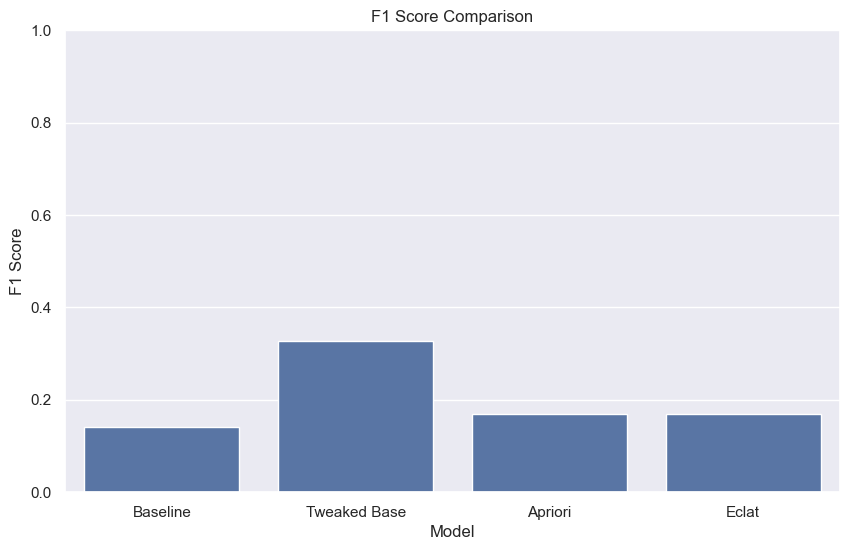

In [60]:
#visualize the results comparing the F1 scores of the baseline, tweaked base, apriori and eclat models using a bar chart
# Create a DataFrame with the F1 scores for each model
f1_scores = pd.DataFrame({'Model': ['Baseline', 'Tweaked Base', 'Apriori', 'Eclat'],
                          'F1 Score': [base_f1, tweaked_base_f1, apriori_f1, eclat_f1]})    
#create the ROC curve   
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1 Score', data=f1_scores)
plt.title('F1 Score Comparison')
plt.ylim(0, 1)
plt.show()
